In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import tensorflow as tf
from numba import jit

In [13]:
x_dim = 2 # dimension of observations
num_clusters = 10
mus = []

sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T

for i in range(num_clusters):
    mus.append(10*np.random.randn(x_dim,1))
    
per_class_sample = 1000 # number of data points
samples = per_class_sample * num_clusters

In [14]:
classes = []
for i in range(num_clusters):
    classes.append(mus[i] + np.random.randn(x_dim,int(per_class_sample)))

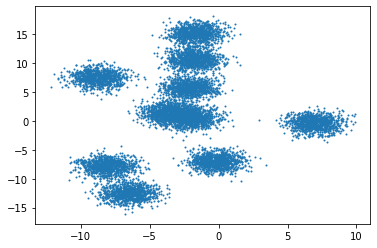

In [15]:
X = np.concatenate(classes, axis=1)
plt.scatter(X[0],X[1],s=1)
plt.show()

In [16]:
Z = np.zeros((2,samples))
Z[0, per_class_sample:] = 1
Z[1, 0:per_class_sample] = 1

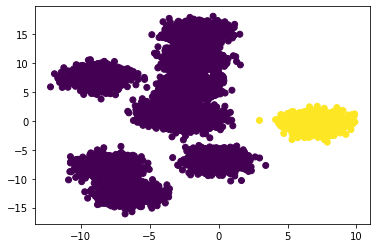

In [17]:
X = np.concatenate(classes, axis=1)
plt.scatter(X[0],X[1],c=Z[1])
plt.show()

## Hard Clustering

In [18]:
W = np.random.randn(num_clusters,x_dim)
theta = np.random.randn(num_clusters,1)
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .1
rho = 5
#idx = np.random.permutation(samples)

#s = np.empty(idx.size, dtype=np.int32)
#for i in np.arange(idx.size):
#    s[idx[i]] = i
    
    
#X = X[:, idx]
#Z = Z[:, idx]

err = [[] for _ in range(samples)]
    
for neural in [False]:
    
    W = 0.5 * np.random.randn(num_clusters,x_dim)
    theta = np.random.randn(num_clusters,1)
    n = np.ones((num_clusters,1))
    Y = np.zeros((num_clusters,samples)) 
    
        
    for t in tqdm(range(samples)):
        x = X[:,t].reshape((x_dim,1))
        a = -W@x + theta
        y = np.zeros((num_clusters,1))
        z = np.zeros(1)

        if neural: ## Neural Step 3

            er  = 1
            itr = 1

            # Iterate until convergence
            while er > 1e-7:

                z_prev = z
                y_prev = y


                # Update y and z
                y = tf.nn.relu(y + (eta)*( -a - z - rho*(np.sum(y, axis=0) - 1) )).numpy()
                z += eta*( np.sum(y, axis=0) - 1 )


                er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                         np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
                err[t].append(er)
                itr += 1


        else: ## Non=Neural Step 3
            c = np.argmin(a)
            y[c] = 1
            z = -a[c]


        #z = z[0]

        #Step 4

        n += y

        for i in range(num_clusters):
            for j in range(x_dim):
                W[i,j] += y[i]*(2*x[j] - W[i,j])/min(n[i], 100)

            theta[i] += y[i]*(z - theta[i])/min(n[i], 100)

        for j in range(num_clusters):
            Y[j,t] = y[j]

    #print(f'Cluster {1} mean: {W[0,:]/2}')
    #for i in range(num_clusters):
    #    print(f'Cluster {i+1} mean: {W[i,:]/2}')
    #print()

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3895.94it/s]


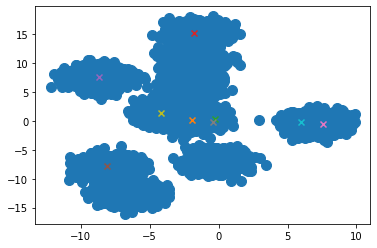

In [19]:
plt.scatter(X[0],X[1],s=100)

for i in range(num_clusters):
    plt.scatter(W[i,0]/2, W[i, 1]/2, marker="x")
plt.show()

## Soft Clustering

## Calculate Means and Sigma

In [466]:
mu_1 = np.sum(Y[:,per_class_sample:], axis=1)/((num_clusters-1)*per_class_sample)
mu_2 = np.sum(Y[:,:per_class_sample], axis=1)/per_class_sample
#Sigma = np.eye(num_clusters)

In [467]:
Sigma = np.cov(Y[:,per_class_sample:])

In [468]:
#e = np.zeros((num_clusters, num_clusters))
#for i in range(num_clusters):
#    e[i,i] = 1

In [469]:
#mu_1 = np.sum([e[i]*per_class_sample for i in range(1,num_clusters)], axis=0)/((num_clusters-1)*per_class_sample)
#mu_2 = e[0]
#Sigma = np.eye(num_clusters)

In [470]:
w_opt = np.linalg.pinv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)

In [471]:
obj_opt = (w_opt.T@(mu_1-mu_2))**2

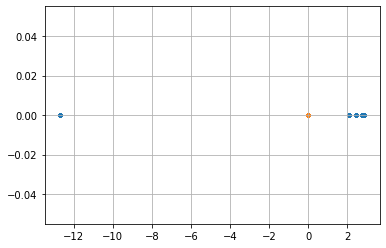

In [472]:
plt.scatter(w_opt.T@Y[:,per_class_sample:],np.zeros((w_opt.T@Y[:,per_class_sample:]).shape),s=10)
plt.scatter(w_opt.T@Y[:,:per_class_sample],np.zeros((w_opt.T@Y[:,:per_class_sample]).shape),s=10)

plt.grid()
plt.show()

In [473]:


def fit(w, l, mu_1, mu_2, Sigma, eta, gam):
    w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
    l = l + gam*((w.T@Sigma@w).item() - 1)
    
    return w, l
        
def run_offline(mu_1, mu_2, Sigma, eta, gam, iters):
    
    w = np.random.randn(num_clusters,1)/np.sqrt(num_clusters)
    l = 1
    
    for i_iter in tqdm(range(iters)):
        w, l = fit(w, l, mu_1, mu_2, Sigma, eta, gam)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
        
    return w

iters = 100000
obj = np.zeros(iters)
err = np.zeros(iters)


def objective(trial):
   

    
    e = trial.suggest_discrete_uniform('eta', 3, 10, q=1)
    g = trial.suggest_discrete_uniform('g', 0, 4, q=1)
    eta = 10**(-e)
    gam = 10**(g) * eta
    w = run_offline(mu_1[:, None], mu_2[:, None], Sigma, eta, gam, iters)
    obj_ = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
    return abs(obj_opt - obj_)/obj_opt

optimize = False
if optimize:
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print(study.best_params)
else:
    eta = 1e-3
    gam = 1 * eta
    #eta = 1e-3
    #gam = 1 * eta
    w = run_offline(mu_1[:, None], mu_2[:, None], Sigma, eta, gam, iters)


100%|██████████| 100000/100000 [00:01<00:00, 70858.97it/s]


In [474]:
err[-1]

1932.7076774241036

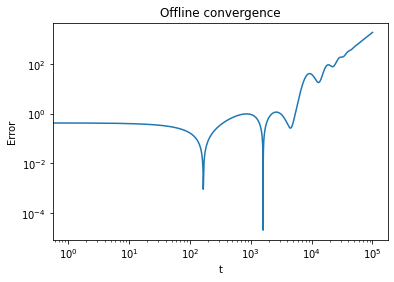

In [475]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Offline convergence")
plt.show()

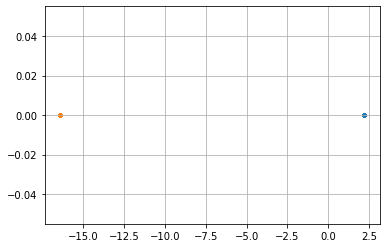

In [348]:
plt.scatter(w.T@Y[:,per_class_sample:],np.zeros((w.T@Y[:,per_class_sample:]).shape),s=10)
plt.scatter(w.T@Y[:,:per_class_sample],np.zeros((w.T@Y[:,:per_class_sample]).shape),s=10)

plt.grid()
plt.show()

In [436]:
e = 1e-1

eta = 1e-4

gam = 1; epochs = 50; iters = epochs*samples

In [437]:
@jit(nopython=True)
def fit_bio(w, l, mu, x, y, zeta, l_, t, eta, gam):
    z = w.T@x - zeta
    
    
    step = eta
    
    if y[1] == 0:
        mu += (x - mu)/t
        zeta += z/t
        w += step*(mu - l*z*(x-mu))
        l += gam*step*(z**2 - 1)
        l_ += 1
        
    else:
        w -= step*l_*x
        l_ = 1
        
        
    return w, l, mu, x, y, zeta, l_

def run_bio(X, Y, eta, gam):
    
    w = np.random.randn(num_clusters)/np.sqrt(num_clusters)
    l = 1
    zeta = 0
    l_ = 1
    
    mu = np.zeros(num_clusters)

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            w, l, mu, x, y, zeta, l_ = fit_bio(w, l, mu, x, y, zeta, l_, t, eta, gam)
            
            obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
            err[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
        
        #print(f'Error: {err_approx[i_iter]}')
    return w

obj = np.zeros(iters)
err = np.zeros(iters)

def objective(trial):
   

    
    e = trial.suggest_discrete_uniform('eta', 3, 6, q=1)
    g = trial.suggest_discrete_uniform('g', 0, 4, q=1)
    eta = 10**(-e)
    gam = 10**(g) * eta
    w = run_bio(Y, Z, eta, gam)
    obj_ = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
    return abs(obj_opt - obj_)/obj_opt

optimize = False
if optimize:
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print(study.best_params)
    
w = run_bio(Y, Z, eta, gam)
    
    



  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-437-720e190e395a>:3: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))

/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))

<ipython-input-437-720e190e395a>:3: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))

/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))

100%|██████████| 50/50 [00:08<00:00,  7.29it/s]


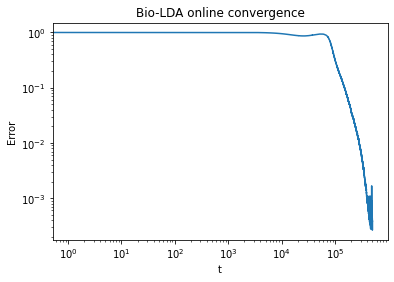

In [438]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Bio-LDA online convergence")
plt.show()

In [439]:
err[-1]

0.0003856344185339229

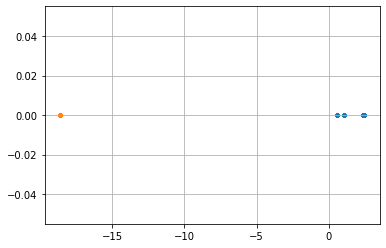

In [435]:
#Y_ = Y[:, s]

plt.scatter(w.T@Y[:,per_class_sample:],np.zeros((w.T@Y[:,per_class_sample:]).shape),s=10)
plt.scatter(w.T@Y[:,0:per_class_sample],np.zeros((w.T@Y[:,0:per_class_sample]).shape),s=10)

plt.grid()
plt.show()

## Soft Clustering

In [18]:
num_clusters = 2
W = np.random.randn(num_clusters,x_dim)
theta = np.zeros((num_clusters,1))
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .1
rho = 5
idx = np.random.permutation(samples)
neural = True
alpha = 10**-2.5
for t in tqdm(range(samples)):
    
    #Initializing Variables
    x = X[:,idx[t]].reshape((x_dim,1))

    a = -W@x + theta
    y = np.zeros((num_clusters,1))
    z = np.zeros(1)

    if neural: ## Neural Step 3
        
        er  = 1
        itr = 1
        
        # Iterate until convergence
        while er > 1e-7:
        
            z_prev = z
            y_prev = y
            
            # Update y and z
            
            y = np.maximum( 0, y + (eta)*(-alpha*t*y/n -a - z - rho*(np.sum(y, axis=0) - 1)) );
            z += eta*(np.sum(y, axis=0) - 1) - 1
            
            
            er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                     np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
            itr += 1
        
    else: ## Non-Neural Step 3
        c = np.argmin(a)
        y[c] = 1
        z = -a[c]
    
    ## Step 4
    n += y

    for i in range(num_clusters):
        for j in range(x_dim):
            W[i,j] += y[i]*(2*x[j] - W[i,j])/n[i]

        theta[i] += y[i]*(z - theta[i])/n[i]

    for j in range(num_clusters):
        Y[j,idx[t]] = y[j]

for i in range(num_clusters):
    print(f'Cluster {i+1} mean: {W[i,:]/num_clusters}')

100%|██████████| 1000/1000 [01:13<00:00, 10.85it/s]

Cluster 1 mean: [10.0270086  -0.03370123]
Cluster 2 mean: [-5.59314843e-03  9.92398284e+00]
